In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
data = pd.read_csv("data/nepal.csv")
data.head(10)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   
6    844359         M        18.25         19.98          119.60     1040.0   
7  84458202         M        13.71         20.83           90.20      577.9   
8    844981         M        13.00         21.82           87.50      519.8   
9  84501001         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010              0.14710   
1          0.08474           0.07864         0.08690              0.07017   
2          0.10960           0.15990         0.19740              0.12790   
3          0.14250           0.28390         0.24140              0.10520   
4          0.10030           0.13280         0.19800              0.10430   
5          0.12780           0.17000         0.15780              0.08089   
6          0.09463           0.10900         0.11270              0.07400   
7          0.11890           0.16450         0.09366              0.05985   
8          0.12730           0.19320         0.18590              0.09353   
9          0.11860           0.23960         0.22730              0.08543   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   
5  ...          23.75           103.40       741.6            0.1791   
6  ...          27.66           153.20      1606.0            0.1442   
7  ...          28.14           110.60       897.0            0.1654   
8  ...          30.73           106.20       739.3            0.1703   
9  ...          40.68            97.65       711.4            0.1853   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   
5             0.5249           0.5355                0.1741          0.3985   
6             0.2576           0.3784                0.1932          0.3063   
7             0.3682           0.2678                0.1556          0.3196   
8             0.5401           0.5390                0.2060          0.4378   
9             1.0580           1.1050                0.2210          0.4366   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  
5                  0.12440          NaN  
6                  0.08368          NaN  
7                  0.11510          NaN  
8                  0.10720          NaN  
9                  0.20750          NaN  

[10 rows x 33 columns]

<Axes: >

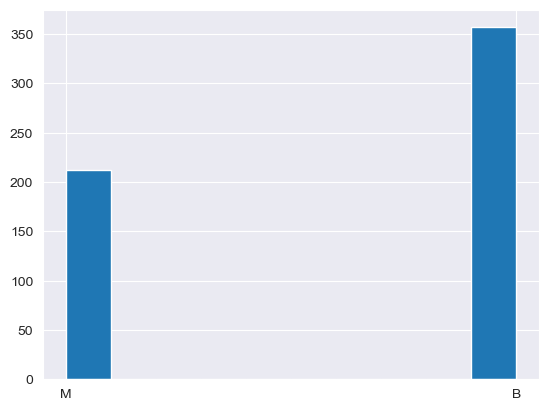

In [31]:
data["diagnosis"].hist()

In [51]:
corr = data.iloc[:,:-1].corr(method="pearson")

<Axes: >

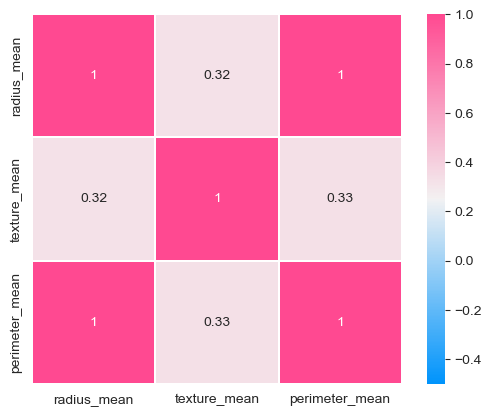

In [52]:
cmap = sns.diverging_palette(250,354,100,60,center='light',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin=-.5,cmap=cmap, square=True,linewidths=.2,annot=True)

In [5]:
data = data[["mean_radius","mean_texture","mean_smoothness","diagnosis"]]
data.head(10)

mean_radius  mean_texture  mean_smoothness  diagnosis
0        17.99         10.38          0.11840          0
1        20.57         17.77          0.08474          0
2        19.69         21.25          0.10960          0
3        11.42         20.38          0.14250          0
4        20.29         14.34          0.10030          0
5        12.45         15.70          0.12780          0
6        18.25         19.98          0.09463          0
7        13.71         20.83          0.11890          0
8        13.00         21.82          0.12730          0
9        12.46         24.04          0.11860          0

<Axes: xlabel='mean_texture', ylabel='Count'>

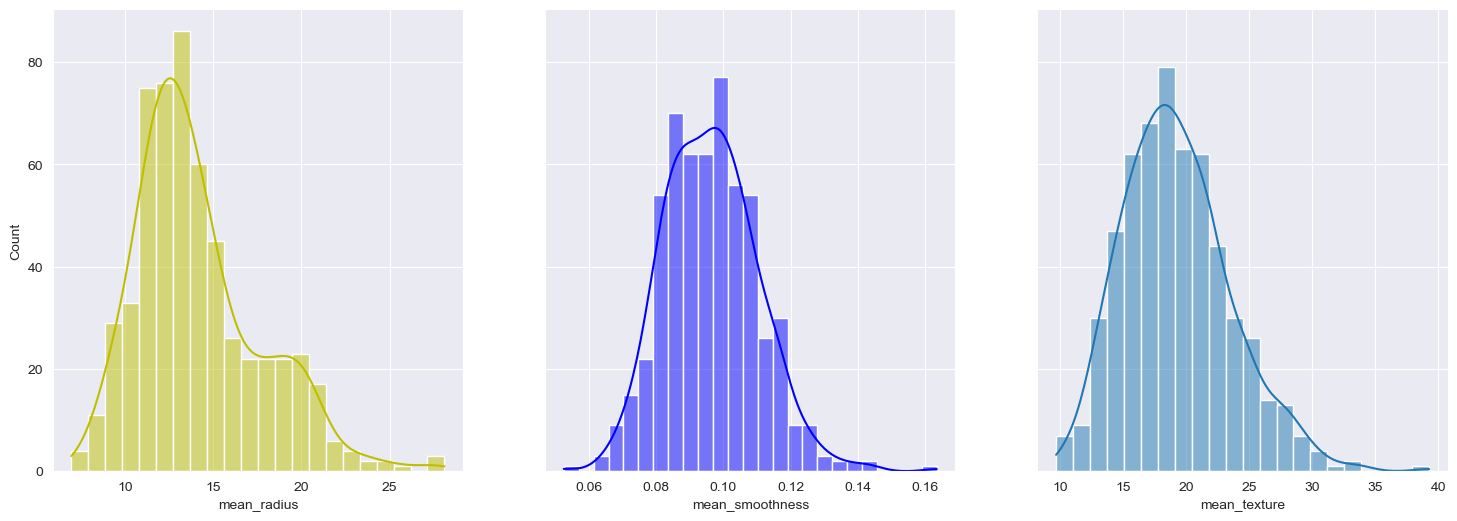

In [14]:
fig, axes = plt.subplots(1,3,figsize=(18,6), sharey=True)
sns.histplot(data, ax=axes[0], x='mean_radius', kde=True, color='y')
sns.histplot(data, ax=axes[1], x='mean_smoothness', kde=True, color='b')
sns.histplot(data, ax=axes[2], x='mean_texture', kde=True)

## Calculate P(Y=y) for all possible y

In [17]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian distribution

In [16]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((feat_val-mean)**2 / (2 * std ** 2)))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=2|Y=y)...P(X=xn|Y=y)*P(Y=y) for all y and find the maximum

In [18]:
def naive_bayes_gaussian(df, X, Y):
    #get feature names
    features = list(df.columns)[:-1]
    
    #calculate prior
    prior = calculate_prior(df, Y)
    
    Y_pred = []
    #loop every data sample
    for x in X:
        #likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])
                
        #calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
        
        Y_pred.append(np.argmax(post_prob))
    
    return np.array(Y_pred)

## Test gaussian model

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=312312)
X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[31  8]
 [ 1 74]]
0.9426751592356688
